# Introduction

In this project I load a dataset with information on superhero characters, clean and analyze the data, filter it in several ways, and build KNN classification models for the different versions of the data and compare the results.  Specifically, I use KNN to classify the characters by creator, using height, weight, intelligence score, strength score, the presence of various different superpowers (via binary variables), and several other numerical variables as independent/predictor variables.  

I filter the data in a few ways, independently:

1. I remove all characters with a trait (i.e. categorical variable) that less than 1% of the total characters have 
(e.g. I removed all characters with gender = 'None' as less than 1% of all characters satisfied that condition) and removed characters from all but the top 6 creators

2. I take only the characters from the top 6 creators (but without otherwise filtering the data)

3. I take only the characters from the top two creators

4. From the data with only characters from the top two creators, I filter out any characters with a trait that has a frequency of less than 1%                

My original was goal just to filter the data to make it easier to work it, since the dataset is so large to begin with, and then I was going to do both a KNN and Naive Baye's model on the filtered data and compare the performance.  However, I figured I should see how the KNN model did on both the filtered and unfiltered data to make sure removing the low-frequency values hadn't had a significant effect.  However, as I played around with filtering the data in various ways and saw that it DID have non-negligible effects on the results, I decided the focus of the project should instead be how well KNN models do on different types of datasets.

In [ ]:
import numpy as np

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

import pandas as pd
pd.options.mode.chained_assignment = None

from dfply import *

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

import plotly.express as px

%load_ext rpy2.ipython

In [170]:
%%R
library(dplyr)
library(ggplot2)
library(caret)

# Read in and clean data

Data source: https://www.kaggle.com/datasets/jonathanbesomi/superheroes-nlp-dataset

Note that I did some of the data cleaning in Excel before importing the file into the Python project, so you need to load the Excel file provided, as the one downloaded directly from Kaggle won't be properly cleaned by the code below, as I wrote the code specifically for the already partially cleaned version of the data.

To be specific as to how I modified the Excel file prior to importing it:

In no particular order:
1. I filled in many of the missing values in the gender column, specifically the ones where the name made the gender
   obvious and/or I was familiar with the character
2. I filled in some of the missing values for creator, race and alignment, going by either personal knowledge of particular
   characters, or by Googling the character
3. I replaced both the cells containing only "-" and the empty cells with cells containing "NaN".
4. I put both the weight and height data into common units, i.e. I converted any meter measurements to cm and any ton measurements to kg.
5. I deleted several of the rows that randomly contained character descriptions and no variable values, as well as empty
   rows
6. I deleted a few rows that contained very little information (i.e. most of the cells were blank)
7. A few of the columns had a few values with differing capitalization (e.g. "blue" vs "Blue" in the eye color column) and I used Excel's "Search and Replace" function  to give them the same capitalization


In [171]:
dropRows = [55, 76, 78, 81, 410, 481, 486, 490, 645, 653, 657, 693,
            697, 840, 827, 830, 842, 844, 949, 950, 1059, 1063, 1077, 1079, 1081]
#original data set had a bunch of rows that contained only text descriptions that ran over from other rows.  
#As the text descriptions aren't a useful variable in my analysis anyway, I'm simply removing this runover text.

superheroData = \
    pd.read_excel("Superhero data.xlsx").\
    drop(dropRows).\
    drop(["full_name"], axis = 1).\
    dropna(how = "all").\
    reset_index()


#Fix format of height and weight variables:
#height data is of the form "6'8 â€¢ 203 cm" which would be very difficult to work with
#hence I'm extracting just the value in centimeters and converting to a float
#similar for weight

columnLength = 1408
comma = ','

for i in range(0, columnLength-1): #final row already has data in the correct form
       
        if str(superheroData["height"][i]) != "nan":
            
            if comma in str(superheroData["height"][i]):
                superheroData["height"][i] = str(superheroData["height"][i]).replace(comma, '')
            
            superheroData["height"][i] = float(str(superheroData["height"][i]).split()[2]) 
                
           
        if str(superheroData["weight"][i]) != "nan":
            
            if comma in str(superheroData["weight"][i]):
                superheroData["weight"][i] = str(superheroData["weight"][i]).replace(comma, '')
            
            superheroData["weight"][i] = float(str(superheroData["weight"][i]).split()[3]) 
                
superheroData[['height', 'weight']].dropna().head() #check that formatting has been successfully applied

,height,weight
2,203.0,441.0
6,191.0,65.0
7,185.0,90.0
8,203.0,441.0
9,183.0,77.0


In [ ]:
superheroData.head()

# Check for and impute missing data values:

Impute numeric variables:

In [173]:
#dfply library allows using pipe decorator to use the pipe operator with user defined functions, 
#so creating a wrapper around base functions allows them to be used with the pipe as well
@pipe
def Rename(df, names):
    return df.rename(columns = names)



In [ ]:
#get numeric variable indexes and names 
encodedVariableIndexes = [i for i in range(18, 68)]


numericVariables = superheroData.iloc[:, [3, 4, 5, 6, 7, 8, 14, 15]] 

#check for nulls before imputing
numericVariables.isnull().sum() >> Print

knnImputer = KNNImputer(n_neighbors = 10)

numericVariablesFilled = \
    pd.DataFrame(knnImputer.fit_transform(numericVariables))

numericVariablesFilled.columns = numericVariables.columns

numericVariablesFilled.isnull().sum()

Impute categorical variables:

In [ ]:
# noinspection PyRedeclaration
encodedVariableIndexes = [i for i in range(18, 68)]

categoricalVariables = superheroData.iloc[:, [1, 2, 9, 10, 11, 12, 13, 16, 17] + encodedVariableIndexes]

categoricalVariables.isnull().sum().head() >> Print


simpleImputer = SimpleImputer(strategy = "most_frequent")

categoricalVariablesFilled = pd.DataFrame(simpleImputer.fit_transform(categoricalVariables))

categoricalVariablesFilled.columns = categoricalVariables.columns


categoricalVariablesFilled.isnull().sum().head()

In [ ]:
superheroDataFilled = pd.concat([categoricalVariablesFilled, numericVariablesFilled], axis = 1)
superheroDataFilled.head()

# Explore and Filter Data:

In [177]:
%%R -i superheroDataFilled -o creatorNamesandCounts

# noinspection PyUnreachableCode
GetNamesandCounts = function(x, variable = 0, variable_name = 0)
{
    Counts = x %>% table() %>% as.vector()

    Names = x %>% unique() %>% unlist() %>% sort()

    if(variable == 0 & variable_name == 0)
	  {
        NamesandCounts = data.frame(Names, Counts) %>% setNames(c('creator names', 'creator counts'))
	  }

    else
	  {
        NamesandCounts = data.frame(Names, Counts) %>% setNames(c(paste0(variable_name, ' names'), paste0(variable_name, ' counts')))
    }
    return(NamesandCounts)
}

creatorNamesandCounts = GetNamesandCounts(superheroDataFilled['creator'])

In [ ]:
creatorsBarChart = px.bar(creatorNamesandCounts, x = 'creator names', y = 'creator counts')
creatorsBarChart.show()

Since, as the above bar graph shows, the vast majority of characters in the data set are from the top 6 creators, the others are unlikely to contribute
meaningfully to the overall patterns and will only complicate the analysis, hence I'll remove them and create a new graph:

In [ ]:
%%R -o superheroData_removed_infrequent_creators

superheroData_removed_infrequent_creators =
superheroDataFilled %>% filter(creator %in% c('Marvel Comics','DC Comics', 'Shueisha', 'Lego', 'Image Comics',
                                              'George Lucas', 'Dark Horse Comics', 'NBC - Heroes'))

creatorNamesandCounts = GetNamesandCounts(superheroData_removed_infrequent_creators['creator'])

#create labels for new graph
labels = function(x)
{
    labels = unlist(round((x/sum(x))*100, 1)) %>% as.vector

    for(i in 1:length(labels))
# noinspection PyUnboundLocalVariable
    {
      labels[i] = paste0(toString(unlist(x)[i]), '\n(', labels[i], '%', ')' )
    }

# noinspection PyStatementEffect,PyRedundantParentheses
    labels
}

# noinspection PyUnboundLocalVariable
labels = labels(creatorNamesandCounts['creator counts'])

# noinspection PyUnboundLocalVariable
ggplot(creatorNamesandCounts, aes(`creator names`, `creator counts`, label = labels)) + # noinspection PyUnboundLocalVariable
       geom_bar(stat = "identity", fill = 'pink', color = "purple", width = 0.75) +
       theme(text = element_text(size=15), axis.text.x = element_text(angle = 90), 
             panel.background = element_rect(fill = 'grey', color = 'grey')) +
       geom_text(vjust = -0.5, label.size = 0.15) +
       scale_y_continuous(limits = c(0, 825))



Further explore data, looking for infrequent values to remove (where I'm defining an infrequent value as a value whose relative frequency in its column is less than 1%)

In [ ]:
%%R -i categoricalVariablesFilled -o categoricalVariableNames

summaryTable = list()

categoricalVariableNames = categoricalVariablesFilled %>% colnames

for(i in 4:length(categoricalVariableNames))
{
    summaryTable[[i-3]] = superheroData_removed_infrequent_creators[paste0(categoricalVariableNames[i])] %>% table
}
summaryTable %>% head(3)

In [28]:
%%R -o superheroDataFiltered

superheroDataFiltered = superheroData_removed_infrequent_creators %>% subset(gender != 'None'  )

In [29]:
%%R -o filteredNamesAndCounts

GetRaceEyeAndHairNameandCounts = function(df)
{
    raceNamesandCounts = GetNamesandCounts(df['type_race'], 'type_race', 'race')

    eyeColorNameandCounts = GetNamesandCounts(df['eye_color'], 'eye_color', 'eye color')

    hairColorNameandCounts = GetNamesandCounts(df['hair_color'], 'hair_color', 'hair color')

# noinspection PyArgumentList, PyRedundantParentheses
    return(list(raceNamesandCounts = raceNamesandCounts, eyeColorNameandCounts = eyeColorNameandCounts, hairColorNameandCounts = hairColorNameandCounts))

}

filteredNamesAndCounts = GetRaceEyeAndHairNameandCounts(superheroDataFiltered)

In [ ]:
def PlotRaceEyeAndHairNameandCounts(df):
    px.bar(df['raceNamesandCounts'], x ='race names', y ='race counts').show()
    px.bar(df['eyeColorNameandCounts'], x ='eye color names', y ='eye color counts').show()
    px.bar(df['hairColorNameandCounts'], x ='hair color names', y ='hair color counts').show()

PlotRaceEyeAndHairNameandCounts(filteredNamesAndCounts)

In [31]:
%%R -o superheroDataFiltered

superheroDataFiltered =
superheroDataFiltered %>% filter(type_race %in% c('Human', 'Mutant', 'Metahuman', 'God/Eternal',
                                              'Alien ', 'Animal', 'Asgardian', 'Android', 'Cyborg','Human/Radiation')) %>%
                        filter(eye_color %in% c('Blue', 'Black', 'Brown', 'Green', 'Red', 'White', 'Yellow')) %>%
                        filter(hair_color %in% c('Black', 'Blond', 'Brown', 'No Hair', 'Red', 'White', 'Grey', 'Green',
                                                'Strawberry', 'Auburn'))


Only Top Two Creators

In [32]:
%%R -o OnlyTop2Creators

OnlyTop2Creators  = superheroDataFilled %>% filter(creator %in% c('Marvel Comics','DC Comics'))

Top two creators filtered data

In [33]:
%%R -o Top2CreatorNamesAndCounts
Top2CreatorNamesAndCounts = GetRaceEyeAndHairNameandCounts(OnlyTop2Creators)

In [ ]:
PlotRaceEyeAndHairNameandCounts(Top2CreatorNamesAndCounts)

In [34]:
%%R -o Top2CreatorsFiltered

Top2CreatorsFiltered = OnlyTop2Creators %>% filter(type_race %in% c('Human', 'Mutant', 'Metahuman', 'Inhuman', 'God/Eternal',
                                                                    'Human/Radiation', 'Alien ', 'Animal', 'Asgardian', 'Android',
                                                                    'Cyborg','Human/Radiation')) %>%
                        filter(eye_color %in% c('Blue', 'Black', 'Brown', 'Green', 'Red', 'White', 'Yellow')) %>%
                        filter(hair_color %in% c('Black', 'Blond', 'Brown', 'No Hair', 'Red', 'White', 'Grey', 'Green',
                                                'Strawberry', 'Auburn', 'Strawberry Blond'))

In [35]:
%%R -o Top2CreatorsFilteredNamesAndCounts
Top2CreatorsFilteredNamesAndCounts = GetRaceEyeAndHairNameandCounts(Top2CreatorsFiltered)

In [ ]:
PlotRaceEyeAndHairNameandCounts(Top2CreatorsFilteredNamesAndCounts)

# KNN Classification: Sort Values by Creator

In [36]:
%%R 
KNN_Classifier = function(df)
{
    set.seed(123)

    training_row_index = createDataPartition(df[,4], p=0.73, list=FALSE)

    training_set = df[training_row_index, 10:67]
    training_class = df[training_row_index, 4]

    test_set = df[-training_row_index, 10:67]
    test_class = df[-training_row_index, 4]

    classifier_knn = train(x = training_set,
                     y = training_class,
                     method = 'knn',
                     preProcess = c("center", "scale"),
                     tuneGrid = data.frame(k = c(1:56)),
                     trControl =
                     trainControl(method = "repeatedcv", number = 5, repeats = 3)
                 )

    outOfSampleResults = predict(classifier_knn, test_set)
    InSampleResults = predict(classifier_knn, training_set)

    outOfSampleError = mean(as.data.frame(outOfSampleResults) != test_class)
    InSampleError = mean(as.data.frame(InSampleResults) != training_class)

    cm = table(Actl = test_class, Pred = outOfSampleResults)

    KvsAccuracyDF = classifier_knn$results[c(1:2)] %>% as.data.frame

    best_k = classifier_knn$bestTune[[1]]

    return(list(KvsAccuracyDF = KvsAccuracyDF, best_k = best_k, outOfSampleResults = outOfSampleResults,
                InSampleResults = InSampleResults, outOfSampleError = outOfSampleError,
                InSampleError = InSampleError, cm = cm, classifier_knn = classifier_knn))

}


Classification of unfiltered data

In [34]:
%%R -o knn_results_unfiltered_data
knn_results_unfiltered_data = KNN_Classifier(superheroDataFilled)

In [35]:
def Show_KNN_Results(KNN_results, confusionMatrixNames = None): #too many categories for it to be worth displaying the confusion matrix for the full dataset,                                                                          #but worth it for the filtered data set
    best_k = KNN_results['best_k'][0]
    outOfSampleError = KNN_results['outOfSampleError'][0]
    InSampleError = KNN_results['InSampleError'][0]

    print("".join(["best k = ", str(best_k)]))
    print("".join(["out of sample error rate of best model = ", str(round(outOfSampleError * 100, 3)), "%"]))
    print("".join(["in sample error rate of best model = ", str(round(InSampleError * 100, 3)), "%"]))

    if confusionMatrixNames is not None:
        confusionMatrix_bestModel = pd.DataFrame(KNN_results['cm'], columns = confusionMatrixNames['columns'], index = confusionMatrixNames['rows'])
        print("Confusion Matrix for best model:")
        print(confusionMatrix_bestModel)

Show_KNN_Results(knn_results_unfiltered_data);

best k = 19
out of sample error rate of best model = 39.167%
in sample error rate of best model = 41.317%


Plot of error of model with varying k value

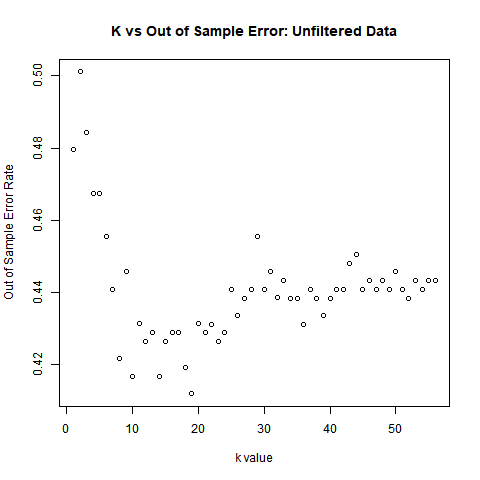

In [29]:
%%R -o x

plotError = function(knn_results, DataName)
{
    plot(x = 1:56, y = 1 - knn_results[['KvsAccuracyDF']][['Accuracy']],
         main = paste0("K vs Out of Sample Error: ", DataName),
         xlab = "k value", ylab = "Out of Sample Error Rate")
}
x = 0

plotError(knn_results_unfiltered_data, DataName = "Unfiltered Data")


Classification of Filtered Data

In [30]:
%%R -o knn_results_filtered_data
knn_results_filtered_data = KNN_Classifier(superheroDataFiltered)

In [31]:
%%R -o names_fd

cmNames = function(knn_results)
{
  cmRows = knn_results$cm %>% row.names
  cmColumns = knn_results$cm %>% colnames

  return(list(columns = cmColumns, rows = cmRows))
}

# noinspection PyUnboundLocalVariable
names_fd = cmNames(knn_results_filtered_data)

In [34]:
Show_KNN_Results(knn_results_filtered_data, confusionMatrixNames = names_fd)

best k = 54
out of sample error rate of best model = 41.224%
in sample error rate of best model = 39.265%
Confusion Matrix for best model:
                   Dark Horse Comics  DC Comics  George Lucas  Image Comics  \
Dark Horse Comics                  0          2             0             0   
DC Comics                          0         27             0             0   
George Lucas                       0          0             0             0   
Image Comics                       0          0             0             0   
Lego                               0          3             0             0   
Marvel Comics                      0         27             0             0   
NBC - Heroes                       0          0             0             0   
Shueisha                           0          0             0             0   

                   Lego  Marvel Comics  NBC - Heroes  Shueisha  
Dark Horse Comics     0              1             0         0  
DC Comics          

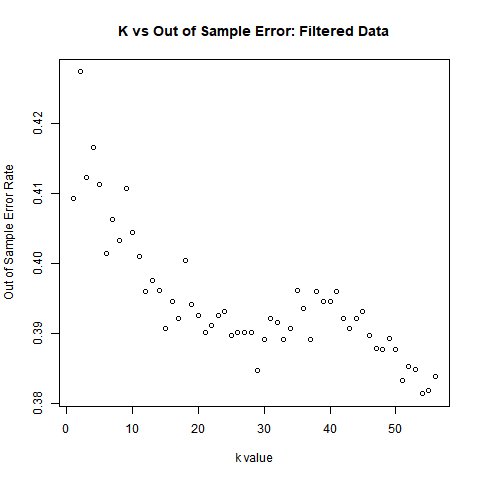

In [35]:
%%R
plotError(knn_results_filtered_data, DataName = "Filtered Data")

Classification of data with only infrequent creator values removed

In [38]:
%%R -o knn_results_no_infrequent_creators
# noinspection PyUnboundLocalVariable
knn_results_no_infrequent_creators = KNN_Classifier(superheroData_removed_infrequent_creators)


In [42]:
%%R -o names

# noinspection PyUnboundLocalVariable
names = cmNames(knn_results_no_infrequent_creators)

In [43]:
Show_KNN_Results(knn_results_no_infrequent_creators, confusionMatrixNames = names)

best k = 18
out of sample error rate of best model = 37.101%
in sample error rate of best model = 35.3%
Confusion Matrix for best model:
                   Dark Horse Comics  DC Comics  George Lucas  Image Comics  \
Dark Horse Comics                  0          0             0             0   
DC Comics                          0         41             0             0   
George Lucas                       0          1             0             0   
Image Comics                       0          0             0             0   
Lego                               0          3             0             0   
Marvel Comics                      0         24             0             0   
NBC - Heroes                       0          1             0             0   
Shueisha                           0          3             0             0   

                   Lego  Marvel Comics  NBC - Heroes  Shueisha  
Dark Horse Comics     0              7             0         0  
DC Comics            

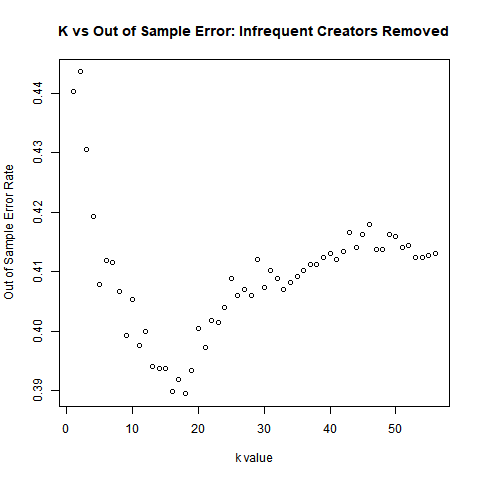

In [45]:
%%R
plotError(knn_results_no_infrequent_creators, DataName = "Infrequent Creators Removed")

Since some of the error seems to come from the model attempting to  classify values from creators other than the top two (as the top creators categories are SO much more frequent then the others, even having removed all the least frequent ones), let's see how the a KNN model does on data containing only values from the top two categories, first without any of the outliers from the other categorical  other variables removed.  Interestingly, the error rate for the KNN model on the data with all the creators but other outliers removed was actually slightly higher than for the completely unfiltered data, so it'll be interesting to see if that's also the case with the filtered vs unfiltered data below.


In [ ]:
%%R -o knn_results_only_2_creators
knn_results_only_2_creators = KNN_Classifier(OnlyTop2Creators)

In [ ]:
%%R -o confusionMatrixNames
confusionMatrixNames = cmNames(knn_results_only_2_creators)

In [48]:
Show_KNN_Results(knn_results_only_2_creators, confusionMatrixNames = confusionMatrixNames)

best k = 11
out of sample error rate of best model = 29.167%
in sample error rate of best model = 26.092%
Confusion Matrix for best model:
               DC Comics  Marvel Comics
DC Comics             44             69
Marvel Comics         22            177


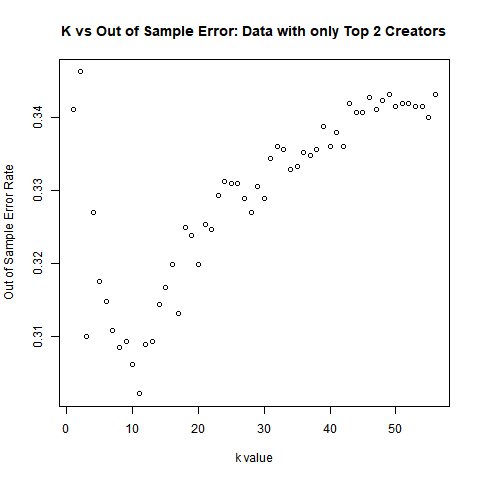

In [49]:
%%R
plotError(knn_results_only_2_creators, DataName = "Data with only Top 2 Creators")

Now let's look at the model on the filtered data:

In [50]:
%%R -o knn_results_Top2CreatorsFiltered
knn_results_Top2CreatorsFiltered = KNN_Classifier(Top2CreatorsFiltered)

In [51]:
%%R -o confusionMatrixNames
confusionMatrixNames = cmNames(knn_results_Top2CreatorsFiltered)

In [52]:
Show_KNN_Results(knn_results_Top2CreatorsFiltered, confusionMatrixNames = confusionMatrixNames)

best k = 17
out of sample error rate of best model = 33.333%
in sample error rate of best model = 26.073%
Confusion Matrix for best model:
               DC Comics  Marvel Comics
DC Comics             23             58
Marvel Comics         19            131


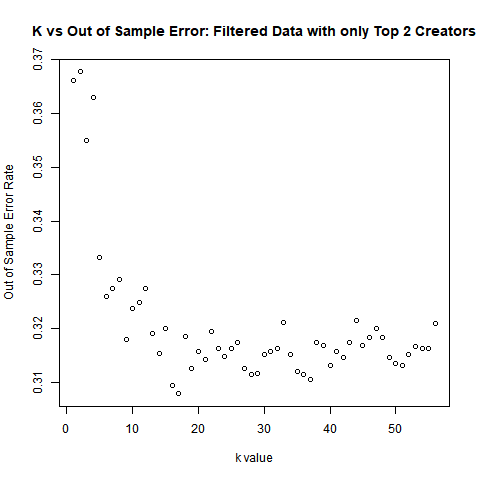

In [53]:
%%R
plotError(knn_results_Top2CreatorsFiltered, DataName = "Filtered Data with only Top 2 Creators")

# Analysis of Results

Looking at the results for the models of the different versions of the data, we can see that removing the filtering the data by infrequent values of the independent models actually made things worse -- it both increased the out-of-sample error rate of the best model and significantly increased the value of k needed for the best model.  

All else constant, a larger k value means a larger bias and smaller variance because because it means we're considering more of the training data in each individual classification. and, hence, there will be more data points that are used for multiple classifications.  Or, in other words, we're looking at a larger amount of the data each time, rather than just the points that happen to be most near a given value, which means looking at more of the big picture each time, which decreases the overall variance.  Unfortunately, it also increases the overall bias because, the more points we consider, the more likely it is that lower frequency categories that may be particularly close to a given value will be "outvoted" by higher frequency categories.  Hence, a model with a larger k value is more likely to be biased towards high-frequency categories, but because of that larger bias will have lower variance.  

Of course, in my particular example, everything else ISN'T constant -- the number of low frequency categories varies and hence the total number of categories varies.  The model with the largest error and largest k value is the one on the data filtered by low frequency values of the indepentent categorical variable, while the model with the smallest k and smallest error is the one on the data with only the top two creators but that's otherwise unfiltered.  And in both cases, decreasing the number of categories in the classifier/dependent variable decreased both the error and the k value, while filtering out low-frequency values of the indepentent variables increased both k and the error.  Additionally, filtering the independent variables had the effect of flattening out the rightside of the k vs error plots, while filtering out the infrequent creators had the opposite effect on the plots.  This all suggests that KNN classification models tend to perform better on data that's more or less evenly split amongst the categories of the classifier variable, which makes sense, as KNN classification uses the mode of the k nearest neighbors, and hence, if some categories have much higher frequencies than others, those high frequency categories will bias the model.  The flattening of the graphs in particular is likely because, with so many low frequency categories getting so completely drowned out by the high frequency categories, after a relatively small k value has been reached, the model is already about as biased as it can get and so increasing k further won't have a very large effect on the bias (and hence the error).  With fewer categories, the error rate and bias are much more sensistive to the size of k.

In the case of this particular dataset, the creator variable is heavily "dominated" (for lack of a better term) by the two highest frequency creators, Marvel and DC.  This evident from the confusion matrices for the top 6 creators data (both filtered and unfiltered) in that almost every predicted classification was for one of those two, and so it's only natural that removing the other creators would result in a more evenly stratified dataset on which KNN would perform better in terms of the error rate.  Even then, it didn't do great because the frequency of Marvel is much larger than that of DC though.  Of note also is that, due to the high bias (and hence large error) caused by the high frequencies of DC and Marvel, the difference between in-sample and out-of-sample error is relatively small for all the models, although it is larger for the model with smaller overal error rates.  That corresponds nicely with the variance increasing as the bias(and error) decrease.

# Naive Bayes' Classification by Creator

In [333]:
def NaiveBayesClassification(df, include_precision_recall_curve = False):

  RandomState(MT19937(SeedSequence(123))) #equivalent to R's set.seed(123)

  #select function and pipe operator are from dfply library
  x = df >> select(range(10,67)) #numeric independent variables
  y = df >> select(X.creator)

  train_set_predictions = []
  test_set_predictions = []
  in_sample_error = []
  out_of_sample_error = []
  in_sample_probs = []
  out_of_sample_probs = []
  classifier_test_sets = []

  #split data, using kfold cross validation
  data_split = StratifiedKFold(n_splits = 30, shuffle = True)
  index = 0
    
  with warnings.catch_warnings(): #ignore needless dataconversionwarning
    warnings.simplefilter('ignore')

    #model = GaussianNB()
    model = ComplementNB()

    for train_index, test_index in data_split.split(x, y):
        x_train, x_test =  x.iloc[train_index], x.iloc[test_index]  # train-test split
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        classifier_test_sets.append(y_test)

        model.fit(x_train, y_train)

        train_set_predictions.append(model.predict(x_train))
        test_set_predictions.append(model.predict(x_test))

        in_sample_error.append( 1 - accuracy_score(y_train.to_numpy(), train_set_predictions[index]) )
        out_of_sample_error.append( 1 - accuracy_score(y_test.to_numpy(), test_set_predictions[index]) )
        index += 1

        in_sample_probs.append(model.predict_proba(x_train))
        out_of_sample_probs.append(model.predict_proba(x_test))

    #average error rate
    mean_percent_error = round(np.mean(in_sample_error)*100, 3)
    print("".join(["Average in-sample error = ", str(mean_percent_error), "%" ]))
    mean_percent_error = round(np.mean(out_of_sample_error)*100, 3)
    print("".join(["\nAverage out of sample error = ", str(mean_percent_error), "%" ]))

    #minimum error rate
    best_model = np.argmin(out_of_sample_error)
    percent_error = round(in_sample_error[best_model]*100, 3)
    print("".join(["\nIn-sample error of best model = ", str(percent_error), "%" ]))
    percent_error = round(out_of_sample_error[best_model]*100, 3)
    print("".join(["\nOut-of-sample error of best model = ", str(percent_error), "%" ]))

    #confusion matrix
    y_actual = classifier_test_sets[best_model]['creator']
    y_actual = pd.Series(y_actual, name = "Actual")
    y_predicted = pd.Series(test_set_predictions[best_model], name = "Predicted", index = y_actual.index)
    print("\nConfusion Matrix for Best Model:")
    print(pd.crosstab(y_actual, y_predicted))

    #get probabilities for best model
    creator_names = dict(enumerate(model.classes_.flatten(), start = 0))
    out_of_sample_probs_best_model = (pd.DataFrame(in_sample_probs[best_model]) >> Rename(names = creator_names))

    print("\nDescriptive statistics for out-of-sample predicted probabilities by best model:")
    print(pd.DataFrame(out_of_sample_probs_best_model.describe()))

    print("\nHistograms of Probabilities for Top Two Creators:")
    fig1 = px.histogram(out_of_sample_probs_best_model, x = "DC Comics")
    fig1.show()
    fig2 = px.histogram(out_of_sample_probs_best_model, x = "Marvel Comics")
    fig2.show()

  #noinspection PySimplifyBooleanCheck
  if include_precision_recall_curve == True:
    precision, recall, thresholds = precision_recall_curve(y_actual, y_predicted,  pos_label = 'Marvel Comics')
    px.line(x = recall, y = precision, title = "Precision-Recall Curve").show()



Unfiltered Data

In [326]:
NaiveBayesClassification(superheroDataFilled)

Average in-sample error = 69.492%

Average out of sample error = 69.602%

In-sample error of best model = 69.728%

Out-of-sample error of best model = 65.957%

Confusion Matrix for Best Model:
Predicted          DC Comics  Marvel Comics
Actual                                     
DC Comics                 14              0
Dark Horse Comics          1              0
Disney                     1              0
Icon Comics                1              0
Image Comics               1              0
Lego                       1              0
Marvel Comics             23              2
NBC - Heroes               1              0
Namco                      1              0
Shueisha                   1              0

Descriptive statistics for out-of-sample predicted probabilities by best model:
        ABC Studios  Blizzard Entertainment            CW        Capcom  \
count  1.361000e+03            1.361000e+03  1.361000e+03  1.361000e+03   
mean   2.365900e-15            2.036790e-15  2.8

Filtered Data

In [327]:
NaiveBayesClassification(superheroDataFiltered)

Average in-sample error = 45.842%

Average out of sample error = 46.143%

In-sample error of best model = 43.128%

Out-of-sample error of best model = 40.0%

Confusion Matrix for Best Model:
Predicted      Marvel Comics
Actual                      
DC Comics                 10
Lego                       1
Marvel Comics             18
Shueisha                   1

Descriptive statistics for out-of-sample predicted probabilities by best model:
          DC Comics  Dark Horse Comics  George Lucas  Image Comics  \
count  8.950000e+02       8.950000e+02  8.950000e+02  8.950000e+02   
mean   2.011173e-02       1.547837e-07  5.079805e-08  2.173079e-08   
std    1.404610e-01       2.650095e-06  9.148240e-07  4.140985e-07   
min    0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.932279e-90       1.362118e-25  1.563023e-27  1.037984e-27   
50%    2.303313e-76       7.217395e-22  1.606312e-23  1.435286e-23   
75%    7.531714e-65       1.602495e-19  6.502078e-21  7.418514e-

Only Top 6 Creators

In [328]:
NaiveBayesClassification(superheroData_removed_infrequent_creators)

Average in-sample error = 66.061%

Average out of sample error = 66.071%

In-sample error of best model = 66.267%

Out-of-sample error of best model = 60.465%

Confusion Matrix for Best Model:
Predicted          DC Comics  Marvel Comics
Actual                                     
DC Comics                 14              0
Dark Horse Comics          1              0
Lego                       1              0
Marvel Comics             22              3
NBC - Heroes               1              0
Shueisha                   1              0

Descriptive statistics for out-of-sample predicted probabilities by best model:
         DC Comics  Dark Horse Comics  George Lucas  Image Comics  \
count  1251.000000       1.251000e+03  1.251000e+03  1.251000e+03   
mean      0.975220       1.564014e-15  4.303740e-16  9.811162e-18   
std       0.155517       5.184090e-14  1.449247e-14  3.395678e-16   
min       0.000000       0.000000e+00  0.000000e+00  0.000000e+00   
25%       1.000000       4.44

Only Top 2 Creators

In [334]:
NaiveBayesClassification(OnlyTop2Creators, include_precision_recall_curve = True)

Average in-sample error = 62.845%

Average out of sample error = 62.892%

In-sample error of best model = 63.214%

Out-of-sample error of best model = 58.974%

Confusion Matrix for Best Model:
Predicted      DC Comics  Marvel Comics
Actual                                 
DC Comics             14              0
Marvel Comics         23              2

Descriptive statistics for out-of-sample predicted probabilities by best model:
         DC Comics  Marvel Comics
count  1120.000000   1.120000e+03
mean      0.985714   1.428571e-02
std       0.118719   1.187191e-01
min       0.000000   0.000000e+00
25%       1.000000   0.000000e+00
50%       1.000000  5.397227e-279
75%       1.000000  1.390715e-233
max       1.000000   1.000000e+00

Histograms of Probabilities for Top Two Creators:


TypeError: unsupported operand type(s) for -: 'str' and 'str'

Top Two Creators: Filtered Data

In [335]:
NaiveBayesClassification(Top2CreatorsFiltered, include_precision_recall_curve = True)

Average in-sample error = 38.192%

Average out of sample error = 38.699%

In-sample error of best model = 36.538%

Out-of-sample error of best model = 32.143%

Confusion Matrix for Best Model:
Predicted      DC Comics  Marvel Comics
Actual                                 
DC Comics              1              9
Marvel Comics          0             18

Descriptive statistics for out-of-sample predicted probabilities by best model:
           DC Comics  Marvel Comics
count   8.320000e+02     832.000000
mean    2.043269e-02       0.979567
std     1.415602e-01       0.141560
min     0.000000e+00       0.000000
25%    1.464065e-119       1.000000
50%    4.616583e-102       1.000000
75%     7.886972e-87       1.000000
max     1.000000e+00       1.000000

Histograms of Probabilities for Top Two Creators:


TypeError: unsupported operand type(s) for -: 'str' and 'str'

Interestingly, in contrast to KNN, Naive Bayes' did very poorly on the unfiltered data, but significantly better on the filtered data.  I suspect that this is because KNN is more of a local algorithm, at least for small values of K, so outliers won't be likely to affect it as much.  Naive Bayes', on the other hand, considers the entire data set when computing probabilities.  Also, oddly, removing the less frequent creators had a much weaker affect than filtering out the characters with infrequent values of the other categorical variables, in contrast to what happened with KNN.  Additionally, removing the less frequent creators seems to have skewed the model somewhat in favor of DC, which is strange, considering that there are nearly twice as many characters from Marvel in the data set.  I suspect that perhaps there are more characters with outlier values of some variables from DC than from Marvel, which may be having an oversized affect on DC.  But then, this only happens with the top 6 creators data, not the top 2, at least, using the ComplementNB model.  I initially was using the GausianNB model, and, in that case, DC dominated Marvel in the top 2 creators data set as well.  We'll need to do some more data exploration to see what's going on here.

Find Outliers in Numeric Variables

In [376]:
scores = superheroDataFilled >> select(range(60, 65))

scores = scores.astype(float)

px.box(scores).show()

df = superheroDataFilled >> select(range(65, 66))
px.box(df).show()

weight = superheroDataFilled >> select(range(66, 67))
px.box(weight).show()


In [362]:
drop_outliers = superheroDataFilled >> filter_by(X.weight < 165.1, X.height < 216)

NaiveBayesClassification(drop_outliers)

Average in-sample error = 58.262%

Average out of sample error = 59.512%

In-sample error of best model = 59.591%

Out-of-sample error of best model = 47.368%

Confusion Matrix for Best Model:
Predicted      DC Comics  J. K. Rowling  Marvel Comics  Shueisha
Actual                                                          
DC Comics              6              0              4         2
George Lucas           0              0              1         0
J. K. Rowling          0              1              0         0
Lego                   0              0              1         0
Marvel Comics          5              0             12         2
NBC - Heroes           0              0              1         0
Nickolodeon            0              0              0         1
Shueisha               0              0              0         1
South Park             0              0              1         0

Descriptive statistics for out-of-sample predicted probabilities by best model:
       ABC 